### Iterative Retrieval with Self Reflection

Iterative retrieval is a dynamic strategy where an AI agent doesn't settle for the first batch of retrieved documents. Instead, it evaluates the adequacy of the initial context, and if necessary it:
* refines the query
* retrieves again
* repeats the process until it's confident enough to answer the original question

In iterative RAG:
* the agent reflects on the retrieved content and the answer it  produced.
* it it's unsure, it can refine it's search (like a human researcher would).

In [2]:
#importing libraries
import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain.chat_models import init_chat_model

d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
urls=['https://docs.langchain.com/oss/python/langchain/agents',
'https://docs.langchain.com/oss/python/langchain/tools',
'https://docs.langchain.com/oss/python/langchain/streaming']

documents = WebBaseLoader(web_paths=urls).load()
chunks = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=100).split_documents(documents)
embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

retriever = FAISS.from_documents(documents=chunks,
                                 embedding=embeddings).as_retriever()

In [4]:
#base model

model = init_chat_model(model="groq:llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001C40479DC90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C4046EFA10>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [5]:
# defining state schema
from pydantic import BaseModel
from typing import List
from langchain_core.documents import Document

class IterativeRAGState(BaseModel):
    question:str
    refined_question: str = ""
    retrieved_docs: List[Document] = []
    answer: str = ""
    verified: bool = False
    attempts: int = 0

In [7]:
# defining nodes
from typing_extensions import TypedDict
from langchain.agents import create_agent
#retrieving docs node

def retrieve_docs(state:IterativeRAGState)->IterativeRAGState:
    #this node retrieves relevant docs for the given question
    relevant_docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": relevant_docs})

#generating answer node

class Context(TypedDict):
    context: str

def generate_answer(state:IterativeRAGState)->IterativeRAGState:
    #this node generates response based on given context information
    combined_doc = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = "generate answer to the given question only using the context information provided"
    gen_answer_agent = create_agent(model=model,
                                    system_prompt=prompt,
                                    context_schema=Context)
    gen_answer_response = gen_answer_agent.invoke({"messages":[{"role":"user", "content": state.question}]}, context=combined_doc)
    return state.model_copy(update={"answer": gen_answer_response['messages'][-1].content})

#answer verifying node
class GenAnswer(TypedDict):
    generated_answer: str
    
def verifying_answer(state:IterativeRAGState)->IterativeRAGState:
    #this function verifies whether generated answer in relevant to the question, if no it provides a feedback for improvement
    self_reflect_prompt ="""
    check if the answer provided for the given question is sufficient and full.
    if answer is satisfactory, give as 'YES', else give as 'NO' with valid feedback for improvement"""
    reflect_model = create_agent(model=model, system_prompt=self_reflect_prompt, context_schema=GenAnswer)
    reflect_model_response =reflect_model.invoke({"messages":[{"role":"user", "content":state.question}]}, context=state.answer)

    verified_response = reflect_model_response['messages'][-1].content
    if "yes" in verified_response.lower():
        return state.model_copy(update={"verified": True, "attempts": state.attempts + 1})
    
#refined question node

def refined_question(state:IterativeRAGState)->IterativeRAGState:
    #this function refines the given question to retrieve documents in better way
    refined_question_prompt = "refine or enhance the given question to the best for better documents retrieval"  
    refined_question_model = create_agent(model=model, system_prompt=refined_question_prompt) 
    refined_question_response = refined_question_model.invoke({"messages":[{"role":"user", "content": state.question}]})
    return state.model_copy(update={"refined_question": refined_question_response['messages'][-1].content})

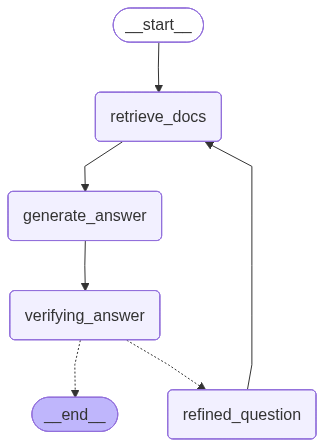

In [10]:
#defining graph workflow

from langgraph.graph import StateGraph, START, END

graph= StateGraph(IterativeRAGState)

graph.add_node("retrieve_docs", retrieve_docs)
graph.add_node("generate_answer", generate_answer)
graph.add_node("verifying_answer", verifying_answer)
graph.add_node("refined_question", refined_question)

graph.add_edge(START, "retrieve_docs")
graph.add_edge("retrieve_docs", "generate_answer")
graph.add_edge("generate_answer", "verifying_answer")
graph.add_conditional_edges("verifying_answer", lambda s: END if s.verified or s.attempts >= 2 else "refined_question",
                            {END: END, "refined_question": "refined_question"} )
graph.add_edge("refined_question", "retrieve_docs")
graph_builder = graph.compile()
graph_builder

In [12]:
#graph invocation

query = "what can tools do to agents?"
state= IterativeRAGState(question=query)
result = graph_builder.invoke(state)
result


{'question': 'what can tools do to agents?',
 'refined_question': '',
 'retrieved_docs': [Document(id='945027fa-f3ce-4cd5-b94a-fb447ca27590', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='For more information, see Tools.\n\u200bDefining tools\nPass a list of tools to the agent.\nTools can be specified as plain Python functions or coroutines.The tool decorator can be used to customize tool names, descriptions, argument schemas, and other properties.\nCopyfrom langchain.tools import tool'),
  Document(id='7ade3525-ebb3-41e2-b352-3a61520a5509', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='create_agent builds a graph-based agent runtime using LangGraph. A graph consists of nodes (steps) and edges (connections) that define how your agent processes information. The agent moves through t

In [20]:
query = "create_retriever_tool in langchain?"
state= IterativeRAGState(question=query)
result = graph_builder.invoke(state)
result

{'question': 'create_retriever_tool in langchain?',
 'refined_question': '',
 'retrieved_docs': [Document(id='54122ace-1ce0-4a82-a02d-1cec04bd3f3e', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='Copyfrom langchain.tools import tool\nfrom langchain.agents import create_agent'),
  Document(id='fa340962-e7c2-45e8-9f2f-f1c93e9e2f50', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/tools', 'title': 'Tools - Docs by LangChain', 'language': 'en'}, page_content='Copyfrom langchain.tools import tool'),
  Document(id='e2e0db20-1f7e-4bbf-bfd2-e63c516160dd', metadata={'source': 'https://docs.langchain.com/oss/python/langchain/agents', 'title': 'Agents - Docs by LangChain', 'language': 'en'}, page_content='Copyfrom langchain.agents import create_agent\nfrom langchain.agents.middleware import wrap_tool_call\nfrom langchain.messages import ToolMessage'),
  Document(id='39a2539d